In [12]:
# conda debug enviornment is created to install latest open3d (0.16.0) with python 3.9
import CGAL
from CGAL.CGAL_Kernel import Polygon_2, Line_2, Segment_2, Point_2, Direction_2, Vector_2, Ray_2, Weighted_point_2
from CGAL.CGAL_Kernel import do_intersect, intersection, squared_distance, orientation, determinant, area, bisector, bounded_side_2, cross_product, left_turn
from CGAL.CGAL_Kernel import COLLINEAR, POSITIVE, NEGATIVE, ORIGIN, CLOCKWISE, COUNTERCLOCKWISE, LEFT_TURN, ON_BOUNDARY, ON_BOUNDED_SIDE, ON_POSITIVE_SIDE, ON_UNBOUNDED_SIDE, ON_NEGATIVE_SIDE
import numpy as np
import pyvisgraph as vg
import matplotlib.pyplot as plt
from matplotlib import cm

import shapely
import osmnx as ox
import shapely.geometry.polygon
import geopandas as gpd
import elevation as dem
import rasterio as rio
from rasterio.warp import Resampling
from rasterio.plot import show
import richdem as rd
import utm
import open3d as o3d
import pandas as pd

# turn response caching off/on
ox.settings.use_cache = True

def plot_vis_graph(g: vg.VisGraph, ax):
    for edge in g.graph.edges:
        ax.plot([edge.p1.x, edge.p2.x], [edge.p1.y, edge.p2.y],
                c=cm.hot(edge.p1.polygon_id/255), ls="solid", marker="o")


def plot_vis_graph_visibile(g: vg.VisGraph, start: vg.Point, ax):
    for pt in g.find_visible(start):
        ax.plot([start.x, pt.x], [start.y, pt.y], c=cm.hot(
            pt.polygon_id/255), ls="dotted", marker="x")


def plot_vis_graph_path(path: list, ax, params="-ro"):
    x, y = [], []
    for pt in path:
        x.append(pt.x)
        y.append(pt.y)
    ax.plot(x, y, params)


def plot_cgal_polygon2(pg, ax, params="-ro"):
    ec = pg.edges_circulator()
    done = ec.next()  # Termination criteria
    while True:  # Circular iterator loop
        e = ec.next()  # Get next iterator element
        # Process
        ax.plot([e.source().x(), e.target().x()], [
                e.source().y(), e.target().y()], params)
        if e == done:  # Check termination criteria
            break  # Exit loop


def plot_cgal_segment2(ls, ax, params="-ro"):
    ax.plot([ls.source().x(), ls.target().x()], [
            ls.source().y(), ls.target().y()], params)


def plot_cgal_line2(ln, ax, params="-ro"):
    ls = Segment_2(ln.point(-1), ln.point(1))
    plot_cgal_segment2(ls, ax=ax, params=params)


def plot_cgal_waypoints(pts, ax, params="-ro"):
    x, y = [], []
    for pt in pts:
        x.append(pt.x())
        y.append(pt.y())
    ax.plot(x, y, params)


def apply_affine_translation_pt(pt: Point_2, ov: Vector_2):
    # Apply 2D affine translation (given by the vector) to the point
    T = np.array(((1, 0, ov.x()), (0, 1, ov.y()), (0, 0, 1)))
    tpt = T.dot(np.array((pt.x(), pt.y(), 1)))
    return Point_2(tpt[0], tpt[1])


def apply_affine_translation_seg(ls: Segment_2, ov: Vector_2):
    # Apply 2D affine translation (given by the vector) to the line segment
    T = np.array(((1, 0, ov.x()), (0, 1, ov.y()), (0, 0, 1)))
    s = T.dot(np.array((ls.source().x(), ls.source().y(), 1)))
    e = T.dot(np.array((ls.target().x(), ls.target().y(), 1)))
    return Segment_2(Point_2(s[0], s[1]), Point_2(e[0], e[1]))


def project_point_on_polygon_hull(pt: Point_2, pg: Polygon_2, offset=0.001):
    # Reverse polygon orientation if required
    if pg.is_clockwise_oriented():
        pg.reverse_orientation()

    closest_edge = None
    edge_distance = float('inf')

    for edge in pg.edges():
        dist = squared_distance(edge, pt)
        if dist < edge_distance:
            edge_distance = dist
            closest_edge = edge

    # Project on the line going through the edge
    closest_pt_on_edge = closest_edge.supporting_line().projection(pt)

    # Check the edge limits
    if closest_pt_on_edge > closest_edge.max():
        closest_pt_on_edge = closest_edge.max()
    elif closest_pt_on_edge < closest_edge.min():
        closest_pt_on_edge = closest_edge.min()

    # Project point at an offset(inward) from the polygon hull.
    dir_vector = closest_edge.supporting_line().perpendicular(
        closest_pt_on_edge).to_vector()
    dir_vector.normalize()
    offset_vector = offset * dir_vector
    proj_pt = apply_affine_translation_pt(closest_pt_on_edge, offset_vector)
    if pg.bounded_side(proj_pt) != ON_BOUNDED_SIDE:
        offset_vector = -offset * dir_vector  # Reverse the direction
        proj_pt = apply_affine_translation_pt(
            closest_pt_on_edge, offset_vector)

    # Find distance and direction, negative for outward, positive for inward, zero for on-boundary
    edge_distance = np.sqrt(squared_distance(pt, proj_pt)) * \
        closest_edge.supporting_line().oriented_side(proj_pt)

    return closest_edge, proj_pt, edge_distance, pg.bounded_side(proj_pt)


def build_visgraph(polys: list):
    g = vg.VisGraph()
    # g.build(polys, workers=8, status=True)
    # Manual build, assuming each polygon vertices are in-order (ccw or cw).
    g.graph = vg.Graph(polys)
    g.visgraph = vg.Graph([])

    for edge in g.graph.edges:
        g.visgraph.add_edge(edge)

    return g


def create_visbility_graph(pg: Polygon_2):
    # Create visibility graph
    polys = [[vg.Point(p.x(), p.y()) for p in pg.vertices()]]
    return build_visgraph(polys)


def calculate_shortest_path(graph: vg.VisGraph, start: Point_2, goal: Point_2, thresh=0.001):
    # Connect to points in the polygon using the visibility graph.
    path = graph.shortest_path(vg.Point(start.x(), start.y()), vg.Point(goal.x(), goal.y()))

    if len(path) < 2:
        print(f"No valid path from {start} to  {goal}.")
        return False, list()

    shortest_path = [Point_2(path[0].x, path[0].y)]
    for pt in path[1:]:
        ppt = shortest_path[-1] # previous point
        npt = Point_2(pt.x, pt.y) # current point
        if squared_distance(ppt, npt) > thresh: # if distance is greather than threshold
            shortest_path.append(npt) # Append to the output list
            
    return True, shortest_path


def compute_traversal_time(start: Point_2, end: Point_2, v_max: float, a_max: float):
    """Compute the time to go from start to end give maximum velocity and acceleration 

    Args:
        start (Point_2): Start point
        end (Point_2): End point
        v_max (float): Maximum velocity
        a_max (float): Maximum acceleration

    Returns:
        time (float): The total time is acceleration time, cruise time, and deacceleration time
    """
    if (v_max < 0) or (a_max < 0):
        print(f"Invalid v_max[{v_max}], a_max[{a_max}]")
        return -1

    distance = np.sqrt(squared_distance(start, end))
    # Time to accelerate or decelerate to or from maximum velocity:
    acc_time = v_max / a_max
    # Distance covered during complete acceleration or decelerate:
    acc_distance = 0.5 * v_max * acc_time
    # Compute total segment time:
    if (distance < 2.0 * acc_distance):
        # Case 1: Distance too small to accelerate to maximum velocity.
        return (2.0 * np.sqrt(distance / a_max))
    else:
        # Case 2: Distance long enough to accelerate to maximum velocity.
        return (2.0 * acc_time) + ((distance - (2.0 * acc_distance)) / v_max)


def camera_frustum_model(altitude: float, fov: float=60.0, overlap: float=0.5):
    """Given the camera parameter and drone height above ground, find the sweep offset
        Note: Refer the diagram [camera_frustum_model.png] 
    Args:
        altitude (float): Drone flight height in meters
        fov (float): Camera FOV (Horizontal/Vertical) in radians. Defaults to 60.
        overlap (float): Desired percentage overlap along fov, [0, PI]. Defaults to 50%.

    Returns:
        sweep_line_offset_dist (float): Offset distane in meters between conscetive sweep lines
    """
    fov = np.deg2rad(fov)
    if (fov > 0) and (fov < np.pi):
        footprint = 2.0 * altitude * np.tan(fov/2.0)
        sweep_distance = (1.0 - overlap) * footprint
        return sweep_distance
    else:
        print(f"Invalid FOV: {fov}, Altitude: {altitude}")
        return -1


def find_camera_height(hfov: float=60, vfov: float=50, width: int=1100, height: int=900, gsd: float=0.03):
    """Find the maximum flying height given camera parameters and desires GSD.

    Args:
        hfov (float, optional): Horizontal field of view in degrees. Defaults to 60.
        vfov (float, optional): Vertical field of view in degrees. Defaults to 50.
        width (int, optional): Camera image width in pixels. Defaults to 1100.
        height (int, optional): Camera image height in pixels. Defaults to 900.
        gsd (float, optional): Desired ground sampling distance [m/pixel]. Defaults to 0.03.

    Projected Area: Lx, Ly
    Lx = width * gsd # Horizontal projection
    Ly = height * gsd # Vertical projection
    
    Geomatric relationship
    Lx = width * gsd = 2 * h * np.tan(hfov/2.0)
    Ly = height * gsd = 2 * h * np.tan(vfov/2.0)
    
    Returns:
        height (float): Maximum flight hight for desired GSD
    """
    hfov = np.deg2rad(hfov)
    vfov = np.deg2rad(vfov)
    hmax_hor = (width * gsd) / (2.0 * np.tan(hfov/2.0))
    hmax_ver = (height * gsd) / (2.0 * np.tan(vfov/2.0))
    hmax = min(hmax_hor, hmax_ver)

    print(f"hmax: {hmax:0.2f}, hmax_hor: {hmax_hor:0.2f}, hmax_ver: {hmax_ver:0.2f}")
    return hmax


def find_cgal_intersections(pg: Polygon_2, ln: Line_2, reverse=False):
    pts = list()
    for e in pg.edges():
        obj = intersection(ln, e)
        if obj.is_Segment_2():
            ls = obj.get_Segment_2()
            if ls.source() not in pts:
                pts.append(ls.source())
            if ls.target() not in pts:
                pts.append(ls.target())

        elif obj.is_Point_2():
            pt = obj.get_Point_2()
            if pt not in pts:
                pts.append(pt)

    perp_ln = ln.perpendicular(ln.point(0))
    return sorted(pts, key=lambda p: squared_distance(perp_ln, p), reverse=reverse)


def find_sweep_segment(pg: Polygon_2, ln: Line_2, min_intersections=0):
    # Same as findIntersections but only return first and last intersection.
    pts = find_cgal_intersections(pg, ln)
    if len(pts) <= min_intersections:
        return False, None
    lsg = Segment_2(pts[0], pts[-1])  # Front and Back
    return True, lsg


def check_same_direction(ls1: Segment_2, ls2: Segment_2):
    """Check if the two line segments have same direction.

    Args:
        ls1 (Segment_2): First line segment
        ls2 (Segment_2): Second line segment

    Returns:
        Bool: True if both have same direction, False otherwise
    """
    v1 = ls1.to_vector()
    v2 = ls2.to_vector()
    v1.normalize()
    v2.normalize()
    dv = v1-v2
    return True if ((abs(dv.x()) < 0.001) and (abs(dv.y()) < 0.001)) else False


def vertices_between_segments(pg: Polygon_2, ls1: Segment_2, ls2: Segment_2):
    """Find the polygon vertices between the ls1 and ls2.
    Calculate the average distances with respect to ls2.

    Args:
        pg (Polygon_2): _description_
        ls1 (Segment_2): _description_
        ls2 (Segment_2): _description_

    Returns:
        vertices list(Point_2): List of vertices between the two line segemnts.
        avgDist (float): Average distance of points wrt ls2.
    """
    l1 = ls1.supporting_line()
    l2 = ls2.supporting_line()
    vertex_dist = list()
    vertices = list()
    avgDist = 0
    for pt in pg.vertices():
        o_wrt_l1 = l1.oriented_side(pt)
        o_wrt_l2 = l2.oriented_side(pt)
        if (o_wrt_l1 == 1) and (o_wrt_l2 == -1) or ((o_wrt_l1 == -1) and (o_wrt_l2 == 1)):
            vertices.append(pt)
            vertex_dist.append(np.sqrt(squared_distance(ls2, pt)))
            avgDist = np.mean(vertex_dist)
            
    return vertices, avgDist


def find_polygon_unique_edge_orientation(pg: Polygon_2):
    """Find all non-collinear edges orientation. 
    If there are collinear edges, keep the one with largest length.

    Args:
        pg (Polygon_2): Input polygong with ordered (CW or CCW) vertices

    Returns:
        edges list(Segment_2): List of unique edge directions.
    """

    # Temporary list inorder to avoid re-calculating edge directions.
    dirs = list()
    edges = list()  # Correponging edges

    for e in pg.edges():
        found = False
        dir = e.to_vector()  # Direction vector from target to source
        for idx, d in enumerate(dirs):
            if (orientation(dir, d)) == COLLINEAR:
                found = True
                if e.squared_length() > edges[idx].squared_length():
                    # Replace edge and directon
                    edges[idx] = e
                    dirs[idx] = dir

        if not found:
            # Direction not already present, thus add it to the list
            dirs.append(dir)
            edges.append(e)

    return edges  # Edges are more useful than only dirs


def compute_waypoints(pg: Polygon_2, graph: vg.VisGraph, sweeps: list(), v_max: float=1.0, a_max: float=1.0, offset: float=0.001):
    waypoints = []
    path_length = 0
    path_time = -1
    
    if len(sweeps) > 1:
        waypoints.append(sweeps[0].source())
        waypoints.append(sweeps[0].target())
        reverse_sweep_path = True
        for sweep in sweeps[1:]:
            if reverse_sweep_path:
                sweep = sweep.opposite()
            reverse_sweep_path = not reverse_sweep_path  # Invert for next sweep-line
            start = sweep.source()
            goal = sweep.target()
            # connect previous segments
            _, origin, _, _ = project_point_on_polygon_hull(waypoints[-1], pg, offset)
            _, destination, _, _ = project_point_on_polygon_hull(start, pg, offset)

            result, path = calculate_shortest_path(graph, origin, destination)
            if result == True:
                for pt in path[1:-1]:
                    waypoints.append(pt)
            # Add current segment
            waypoints.append(start)
            waypoints.append(goal)

        ppt = waypoints[0]
        for pt in waypoints[1:]:
            path_length += np.sqrt(squared_distance(ppt, pt))
            path_time += compute_traversal_time(ppt, pt, v_max, a_max)
            ppt = pt

    return waypoints, path_length, path_time


def compute_sweep_lines(pg: Polygon_2, start: Segment_2, offset: float, ccw: bool):
    sweeps = list()  # Output
    sq_offset = offset * offset  # Used by observability

    # Input polygon must have ccw orientation
    if pg.is_clockwise_oriented():
        pg.reverse_orientation()

    # Find start sweep
    sweep = start.supporting_line()
    # print(f"CCW-Direction: {ccw}")

    # Calculate sweep offset using sensor model parameters
    offset_dir = sweep.perpendicular(start.source()).direction()  # Vector_2
    offset_vector = Vector_2(offset_dir.dx(), offset_dir.dy())
    offset_vector.normalize()
    offset_vector = offset * offset_vector
    # print(f"OffsetVector: {offset_vector}")

    result, sweep_segment = find_sweep_segment(pg, sweep)
    sweep_segment = sweep_segment.opposite() if ccw else sweep_segment
    print(f"StartingSweepLine: {sweep_segment}")
    
    while result is True:
        # Align sweep segment
        sweeps.append(sweep_segment)

        # Find next sweep segment
        # Translate the sweep segement by applying affine translation
        # Previous line segment
        prev_sweep_segment = sweep_segment
        sweep = apply_affine_translation_seg(sweep_segment, offset_vector)
        result, sweep_segment = find_sweep_segment(pg, sweep.supporting_line())
        if result == True:
            # Reverse direction if find_sweep_segment calculated opposite direction
            if sweep_segment.is_degenerate():
                sweeps.append(sweep_segment)
                result = False
            elif check_same_direction(prev_sweep_segment, sweep_segment) == False:
                sweep_segment = sweep_segment.opposite()

        # Add a final sweep wrt to last sweep segment, if possible
        if  result == False:
            vertices, avg_dist = vertices_between_segments(pg, sweep, prev_sweep_segment)
            # Don't add very close sweep segments
            if (len(vertices) == 0) or (avg_dist < (offset/2.0)):
                break

            offset_vector.normalize()
            offset_vector = avg_dist * offset_vector
            # Translate the sweep segement by applying affine translation
            sweep = apply_affine_translation_seg(prev_sweep_segment, offset_vector)
            result, sweep_segment = find_sweep_segment(pg, sweep.supporting_line())
            if result:
                if check_same_direction(prev_sweep_segment, sweep_segment) == False:
                    sweeps.append(sweep_segment.opposite())
                else:
                    sweeps.append(sweep_segment)
                break

    return True, sweeps


def compute_all_sweeps(pg: Polygon_2, sweep_offset: float):
    # Compute sweeps for all sweepable directions counter-clockwise and clockwise.
    sweeps_cluster = list()

    # Find all sweepable directions
    dirs = find_polygon_unique_edge_orientation(pg)
    g = create_visbility_graph(pg)
    for dir in dirs:
        # Find Sweep without inverting dir vector
        result, sweeps = compute_sweep_lines(pg, dir, sweep_offset, False)
        if result:
            # sweeps_cluster.append(sweeps)
            waypoints, path_length, path_time = compute_waypoints(pg, g, sweeps, 1, 1, 0.001)
            print(f"PathLength: {path_length:0.2f}, TraversalTime: {path_time:0.2f}, Turns: {len(waypoints)-2}")
            if len(waypoints) > 1:
                sweeps_cluster.append(waypoints)
                
        # Find Sweep by inverting dir vector
        result, sweeps = compute_sweep_lines(pg, dir, sweep_offset, True)
        if result:
            # sweeps_cluster.append(sweeps)
            waypoints, path_length, path_time = compute_waypoints(pg, g, sweeps, 1, 1, 0.001)
            print(f"PathLength: {path_length:0.2f}, TraversalTime: {path_time:0.2f}, Turns: {len(waypoints)-2}")
            if len(waypoints) > 1:
                sweeps_cluster.append(waypoints)
                
    return sweeps_cluster


def optimal_sweep_edge(pg: Polygon_2):
    min_dir = None
    min_altitude = float('inf')
    for dir in find_polygon_unique_edge_orientation(pg):
        for e in pg.edges():
            alt = np.sqrt(squared_distance(dir, e))
            if (alt > 0) and (alt < min_altitude):
                min_altitude = alt
                min_dir = dir
            
    return min_dir, min_altitude


def lidar_model(vfov = 30, hres=1, vres=1):
    direction = []
    for theta in np.arange(0, 2*np.pi, hres*np.pi/180.0):
        for phi in np.arange(-(vfov/2.0)*np.pi/180.0 + np.pi/2, (vfov/2.0)*np.pi/180.0 + np.pi/2, vres*np.pi/180.0):
            x = np.sin(phi) * np.cos(theta)
            y = np.sin(phi) * np.sin(theta)
            z = np.cos(phi)
            direction.append([x, y, z])
    return direction


def lidar_scan(pos, model):
    pts = [[pos[0], pos[1], pos[2], dir[0], dir[1], dir[2]] for dir in model] 
    return o3d.core.Tensor(pts, dtype=o3d.core.Dtype.Float32)


def extrude_polygon_sides(pg, height=1):
    vtx = pg.copy()  # copy original ist
    tri_idx = []
    N = len(pg)
    for idx in range(0, N-1):
        pt = pg[idx]
        vtx.append([pt[0], pt[1], pt[2]+height])  # Add extruded point
        tri_idx.append([idx, idx+1, N+idx])
        tri_idx.append([idx+1, N+idx+1, N+idx])
    # Add last point
    pt = pg[-1]
    vtx.append([pt[0], pt[1], pt[2]+height])  # Add extruded point
    return vtx, tri_idx


def get_osm_buildings_with_dem(roi=(51.8903, 10.41933), zone_num=32, zone_letter='U', upscale_factor = 30):

    # Get OSM
    gdf = ox.geometries_from_point(roi, dist=200, tags={'building': True})
    print('Bbox: ', gdf.total_bounds)

    # Get DEM
    offset = 0.0005
    bbx = gdf.total_bounds
    bbx = (bbx[0]-offset, bbx[1]-offset, bbx[2]+offset, bbx[3]+offset)

    fname = f"{os.getcwd()}/ROI-DEM.tif"
    dem.clip(bounds=(bbx[0], bbx[1], bbx[2], bbx[3]),
             output=fname, product='SRTM1')
    dem.clean()  # clean up stale temporary files and fix the cache in the event of a server error
    dem_data = rio.open(fname)

    # Resample DEM
    dem_array = dem_data.read(1,
                              out_shape=(int(dem_data.height * upscale_factor),
                                         int(dem_data.width * upscale_factor)),
                              out_dtype=np.double,
                              resampling=Resampling.bilinear
                              )

    # DEM image transform
    dem_transform = dem_data.transform * dem_data.transform.scale(
        (dem_data.width / dem_array.shape[-1]),
        (dem_data.height / dem_array.shape[-2])
    )

    # Get elevation at pt(lng, lat) and convert to utm wrt first polygon point
    start_lng_lat = gdf.loc[gdf.index[0]].geometry.exterior.coords[0]
    start_alt = dem_array[rio.transform.rowcol(
        dem_transform, start_lng_lat[0], start_lng_lat[1])]
    start_east, start_north, _, _ = utm.from_latlon(
        start_lng_lat[1], start_lng_lat[0], zone_num, zone_letter)  # Note lat, lng order
    start_pt = [start_east, start_north, start_alt]
    print(start_pt)
    geoms = []
    ground = []
    for geom in gdf.geometry:
        pts = []
        for pt in geom.exterior.coords:
            lng = pt[0]
            lat = pt[1]
            alt = dem_array[rio.transform.rowcol(dem_transform, lng, lat)]
            east, north, _, _ = utm.from_latlon(
                lat, lng, zone_num, zone_letter)
            # abs_pos = [east, north, alt]
            rel_pos = [east-start_pt[0], north-start_pt[1], alt-start_pt[2]]
            pts.append(rel_pos)
            ground.append(rel_pos)

        geoms.append(pts)

    convex_hull = gdf.unary_union.convex_hull
    roi_polygon = []
    for pt in convex_hull.exterior.coords:
        lng = pt[0]
        lat = pt[1]
        alt = dem_array[rio.transform.rowcol(dem_transform, lng, lat)]
        east, north, _, _ = utm.from_latlon(
            lat, lng, zone_num, zone_letter)
        rel_pos = [east-start_pt[0], north-start_pt[1], alt-start_pt[2]]
        roi_polygon.append(rel_pos)

    
    return geoms, ground, roi_polygon 


def show_dem(fname=f"{os.getcwd()}/ROI-DEM.tif", upscale_factor=30):
    with rio.open(fname) as dem_data:
        # dem_array = dem_data.read(1).astype('float64')
        dem_array = dem_data.read(1,
                                  out_shape=(int(dem_data.height * upscale_factor),
                                             int(dem_data.width * upscale_factor)),
                                  out_dtype=np.double,
                                  resampling=Resampling.bilinear
                                  )

        dem_richdem = rd.rdarray(dem_array, no_data=-9999)
        fig = rd.rdShow(dem_richdem, axes=False,
                        cmap='viridis', figsize=(12, 10))
    return fig


def dem_coordinates(fname=f"{os.getcwd()}/ROI-DEM.tif", upscale_factor=30):
    with rio.open(fname) as dem_data:
        # band1 = dem_data.read(1).astype('float64')
        band1 = dem_data.read(1,
                              out_shape=(int(dem_data.height * upscale_factor),
                                         int(dem_data.width * upscale_factor)),
                              out_dtype=np.double,
                              resampling=Resampling.bilinear
                              )
        print('Band1 has shape', band1.shape)
        height = band1.shape[0]
        width = band1.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rio.transform.xy(dem_data.transform, rows, cols)
        lngs = np.array(xs)
        lats = np.array(ys)
        pts = []
        for y, lat in enumerate(lats[0, 50:-50]):
            for x, lng in enumerate(lngs[0, 50:-50]):
                pts.append([lng, lat, band1[(x, y)]])
    return lats, lngs, pts


def create_open3d_waypoints(points: list(), color=[1,0,0], zoffset=0):
    """Create Open3D Lineset from given list of points

    Args:
        points (list(list([x,y,z]))): List of lists containing points Cartesian coordinates [x,y,z]
        color (list, optional): Color [R, G, B]. Defaults to [1,0,0].

    Returns:
        LineSet: Open3D LineSet object
    """
    points = [[pt[0], pt[1], pt[2]+zoffset] for pt in points]
    lines = [[idx-1, idx] for idx in range(1,len(points))] # Create consective point as line
    colors = [color for i in range(len(lines))]
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    # o3d.visualization.draw_geometries([line_set])
    # mesh = line_set.extrude_linear([0,1,0])
    # o3d.visualization.draw_geometries([mesh])
    return line_set


print(f"CGAL Version: {CGAL.__version__}")
print(f"Open3D Version: {o3d.__version__}")
print(f"GeoPandas Version: {gpd.__version__}")
print(f"Shapely Version: {shapely.__version__}")
print(f"OSMnx Version: {ox.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"RasterIO Version: {rio.__version__}")

CGAL Version: 5.5.1
Open3D Version: 0.16.0
GeoPandas Version: 0.12.1
Shapely Version: 1.8.5.post1
OSMnx Version: 1.0.1
Pandas Version: 1.5.2
Numpy Version: 1.23.5
RasterIO Version: 1.3.4


/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
ERROR 1: PROJ: proj_create_from_name: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed


Bbox:  [10.416618  51.8886251 10.4212208 51.8923425]
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.4443b4a67d5d453db7fd98b32735d4bc.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 10.416117999999999 51.8928425 10.421720800000001 51.888125099999996 SRTM1.4443b4a67d5d453db7fd98b32735d4bc.vrt /home/ahmad/personal_ws/src/ROSExamples/script/ROI-DEM.tif
rm -f SRTM1.4443b4a67d5d453db7fd98b32735d4bc.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Enteri

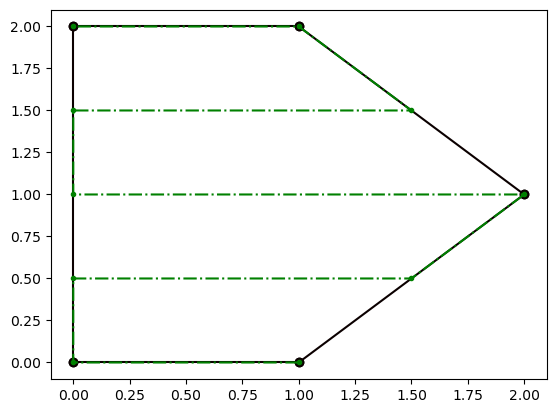

In [60]:
buildings, ground, roi_hull = get_osm_buildings_with_dem(roi=(51.8903, 10.41933)); # Rammelsberg
meshes = []
for building in buildings:
    vtx, tri_dix = extrude_polygon_sides(building, 15)
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vtx), o3d.utility.Vector3iVector(tri_dix))
    mesh.compute_vertex_normals()
    # mesh.vertex_colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(vtx), 3)))
    mesh.paint_uniform_color([np.random.random_sample(), np.random.random_sample(), np.random.random_sample()])        
    meshes.append(mesh)

ground_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground))
ground_pcd.estimate_normals()
ground_pcd.orient_normals_to_align_with_direction()
ground_mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(ground_pcd, depth=6)
ground_mesh.paint_uniform_color([np.random.random_sample(), np.random.random_sample(), np.random.random_sample()])        
meshes.append(ground_mesh)

roi_hull_pcd = create_open3d_waypoints(roi_hull, [1, 0, 0], 30)
meshes.append(roi_hull_pcd)
o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True, point_show_normal=True, mesh_show_wireframe=False, window_name=f"Playground: {len(meshes)}")

pg1 = Polygon_2([Point_2(0, 0), Point_2(1, 0), Point_2(2, 1), Point_2(1, 2), Point_2(0, 2)]) # Pentagon

pgx = pg1
print(f"isSimple: {pgx.is_simple()}")
print(f"isConvex: {pgx.is_convex()}")
dirs = find_polygon_unique_edge_orientation(pgx)
print(f"find_polygon_unique_edge_orientation:")
for dir in dirs:
    print(dir)

g = create_visbility_graph(pgx)
plot_vis_graph(g, plt.gca())
print(f"compute_sweep_lines:")
result, sweeps = compute_sweep_lines(pgx, dirs[0], 0.5, False)
if result:
    waypoints, path_length, path_time = compute_waypoints(pgx, g, sweeps, 1, 1, 0.001)
    print(f"PathLength: {path_length:0.2f}, TraversalTime: {path_time:0.2f}, Turns: {len(waypoints)-2}")
    if len(waypoints) > 1:
    #     print(f"Waypoints:")
    #     for wp in waypoints:
    #         print(wp)
        plot_cgal_waypoints(waypoints, plt.gca(), "-.g.")


In [54]:
for pt in roi_hull:
    print(pt)


[-37.08611609891523, -214.97763398941606, -2.0]
[-108.31149166356772, -171.41827975399792, 9.0]
[-125.82910777826328, -142.55501224379987, 9.0]
[-195.96811139350757, 93.26386763807386, -5.0]
[-199.2365078261355, 109.46572355832905, -4.0]
[-200.38815052539576, 129.73619438428432, -5.0]
[-199.88380887790117, 137.77860668301582, -5.0]
[-199.37925309909042, 145.80989787261933, -6.0]
[-32.31827115023043, 195.5680562350899, -3.0]
[-15.252354559488595, 199.02700608037412, 1.0]
[100.52230908244383, 40.377314588055015, 31.0]
[102.40051206899807, 33.026640304364264, 31.0]
[121.0295218527317, -104.56594307906926, 45.0]
[37.44549585448112, -203.5004714243114, 10.0]
[30.80520057794638, -206.12208862043917, 8.0]
[-37.08611609891523, -214.97763398941606, -2.0]


OptimalSweepEdge: [1 0 2 1] OR [2 1 1 0], Altitude: 1.0
StartingSweepLine: 1 0 0 0
PathLength: 9.41, TraversalTime: 17.19, Turns: 8
StartingSweepLine: 0 0 1 0
PathLength: 9.41, TraversalTime: 17.19, Turns: 8
StartingSweepLine: 1 -0 2 1
PathLength: 8.86, TraversalTime: 16.33, Turns: 8
StartingSweepLine: 2 1 1 -0
PathLength: 9.26, TraversalTime: 16.84, Turns: 8
StartingSweepLine: 1 2 2 1
PathLength: 8.86, TraversalTime: 16.33, Turns: 8
StartingSweepLine: 2 1 1 2
PathLength: 9.26, TraversalTime: 16.84, Turns: 8
StartingSweepLine: -0 -0 -0 2
PathLength: 9.41, TraversalTime: 16.19, Turns: 8
StartingSweepLine: -0 2 -0 -0
PathLength: 9.41, TraversalTime: 16.19, Turns: 8


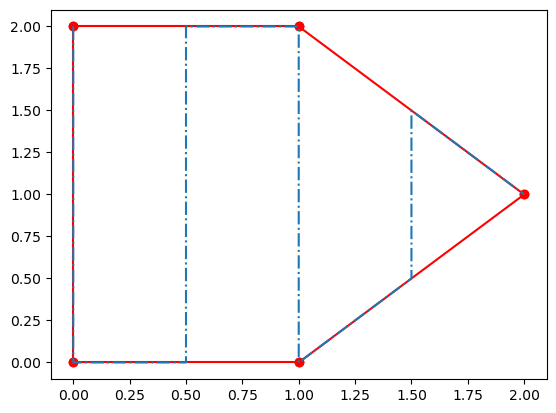

In [7]:
# Degnearate issue with pg9 (cross shape)
pgx = pg1
dir, alt = optimal_sweep_edge(pgx)
print(f"OptimalSweepEdge: [{dir}] OR [{dir.opposite()}], Altitude: {alt}")
sweeps = compute_all_sweeps(pgx, 0.5)
plot_cgal_polygon2(pgx, plt.gca())
for sweep in sweeps[-1:]:
    plot_cgal_waypoints(sweep, plt.gca(), "-.")


In [66]:
find_camera_height(60, 50, 1100, 900, 0.03)
print(camera_frustum_model(30, 60, 0.75))

hmax: 28.58, hmax_hor: 28.58, hmax_ver: 28.95
8.660254037844386
